# SNR finder ANN model training

In [1]:
import numpy as np
import pandas as pd
from ler.utils import add_dict_values
import tensorflow as tf

# tf.config.threading.set_intra_op_parallelism_threads(6)
# tf.config.threading.set_inter_op_parallelism_threads(2)

## Define all the necessary functions

* Functions for scaling the data

In [2]:
import scipy.stats as stats
from scipy.stats import norm

def uniform_to_gaussian(x, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Transform to U(0,1)
    U = x / abs(upper_bound - lower_bound)

    # Transform to standard normal
    Z = norm.ppf(U)

    # If you want a normal distribution with mean mu and standard deviation sigma
    X = mu + sigma * Z
    return X

def gaussian_to_uniform(X, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Reverse the normal scaling to standard normal
    Z = (X - mu) / sigma

    # Transform standard normal back to U(0,1)
    U = norm.cdf(Z)

    # Scale U(0,1) back to U(0, 0.8)
    x = abs(upper_bound - lower_bound) * U
    return x

def sine_to_gaussian(X):
    uniform = (np.cos(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_sine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    sine = np.arccos(2 * uniform - 1)  # Convert to the sine of the angle
    return sine

def cosine_to_gaussian(X):
    uniform = (np.sin(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_cosine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    cosine = np.arcsin(2 * uniform - 1)  # Convert to the cosine of the angle
    return cosine

def scale_to_range(X, min_data=None, max_data=None, min_target=0+0.0001, max_target=np.pi-0.0001):
    if min_data is None:
        min_data = np.min(X)
    if max_data is None:
        max_data = np.max(X)
    X_std = (X - min_data) / (max_data - min_data)
    X_scaled = X_std * (max_target - min_target) + min_target
    return X_scaled

def unscale_to_range(X, min_data, max_data, min_target=0+0.0001, max_target=np.pi-0.0001):
    X_scaled = (X - min_target) / (max_target - min_target)
    X_unscaled = X_scaled * (max_data - min_data) + min_data
    return X_unscaled

# for saving min max values for scaling as json
# def save_min_max(data_dict, filename):
#     min_max = {}
#     for i, key in enumerate(data_dict):
#         min_max[key] = [np.min(data_dict[key]), np.max(data_dict[key])]
#     with open(filename, 'w') as f:
#         json.dump(min_max, f)

## Get all necessary data

In [3]:
from ler.utils import append_json, get_param_from_json
import numpy as np

# these are pre-generated datas
# join all dictionaries into one
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['L1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
# unlensed_params['L1']<10000 => Error: 4.13%
# unlensed_params['L1']<100 => Error: 4.05%
# unlensed_params['L1']<50 => Error: 4.16%
idx_constrain = unlensed_params['L1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['L1'])

216908


216856

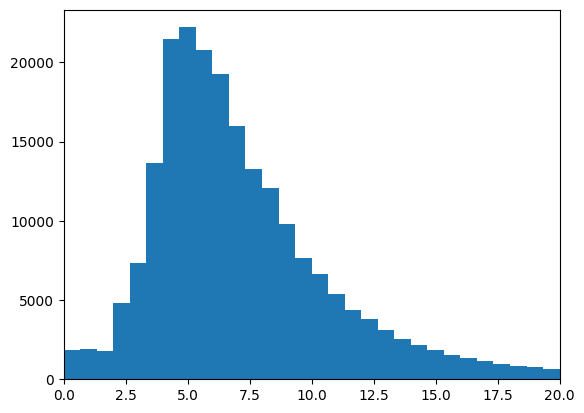

In [4]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['L1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [5]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['L1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


## Input-Output generator function

In [6]:
# from gwsnr import antenna_response_array, cubic_spline_interpolator2d

# def input_output(idx, params):

#     mass_1 = np.array(params['mass_1'])[idx]
#     mass_2 = np.array(params['mass_2'])[idx]
#     luminosity_distance = np.array(params['luminosity_distance'])[idx]
#     theta_jn = np.array(params['theta_jn'])[idx]
#     psi = np.array(params['psi'])[idx]
#     geocent_time = np.array(params['geocent_time'])[idx]
#     ra = np.array(params['ra'])[idx]
#     dec = np.array(params['dec'])[idx]
    
#     detector_tensor = gwsnr.detector_tensor_list
#     snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
#     ratio_arr = gwsnr.ratio_arr
#     mtot_arr = gwsnr.mtot_arr
    
#     size = len(mass_1)
#     len_ = len(detector_tensor)
#     mtot = mass_1 + mass_2
#     ratio = mass_2 / mass_1
#     # get array of antenna response
#     Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

#     Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
#     eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
#     A1 = Mc ** (5.0 / 6.0)
#     ci_2 = np.cos(theta_jn) ** 2
#     ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
#     size = len(mass_1)
#     snr_half_ = np.zeros((len_,size))
#     d_eff = np.zeros((len_,size))

#     # loop over the detectors
#     for j in range(len_):
#         # loop over the parameter points
#         for i in range(size):
#             snr_half_coeff = snr_halfscaled[j]
#             snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
#             d_eff[j,i] =luminosity_distance[i] / np.sqrt(
#                     Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
#                 )

#     #amp0
#     amp0 =  A1 / d_eff

#     # get spin parameters
#     a_1 = np.array(params['a_1'])[idx]
#     a_2 = np.array(params['a_2'])[idx]
#     tilt_1 = np.array(params['tilt_1'])[idx]
#     tilt_2 = np.array(params['tilt_2'])[idx]
#     # phi_12 = np.array(params['phi_12'])[idx]
#     # phi_jl = np.array(params['phi_jl'])[idx]

#     # effective spin
#     chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


#     # input data
#     # error=2.41%, 3.60%
#     # 4.93%, 3.46%
#     # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2]).T
#     # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2]).T
#     # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2]).T

#     # error=2.72%, 3.32%
#     # 4.73%, 3.19%
#     # 3.20%
#     # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
#     # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
#     # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

#     # error=2.79%, 3.28%
#     # 4.46%, 3.18%
#     # 3.27%
#     XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
#     XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
#     XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

#     # output data
#     # get L1 snr for y train
#     yL1 = params['L1'][idx]
#     yH1 = params['H1'][idx]
#     yV1 = params['V1'][idx]

#     return(XL1, XH1, XV1, yL1, yH1, yV1)

In [7]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get L1 snr for y train
    yL1 = params['L1'][idx]

    return(XL1, yL1)

In [8]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, yL1 = input_output(idx, unlensed_params)
np.shape(XL1)

(216856, 5)

In [9]:
#concatenate XL1, yL1
data_ = np.concatenate((XL1, yL1[:,None]), axis=1)

## Initial scaling of the input data

### Half-SNR

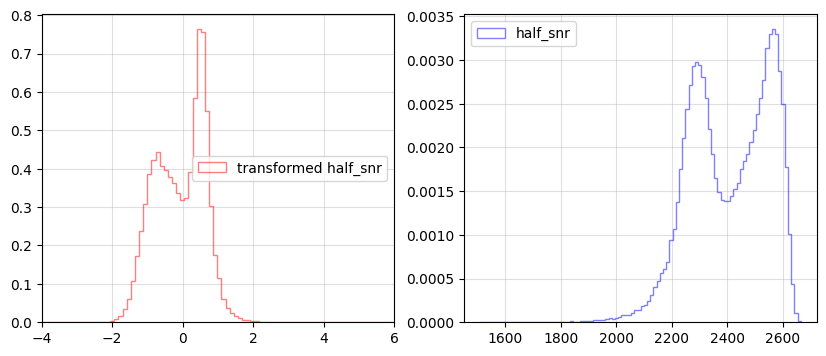

In [10]:
half_snr = data_[:,0]
#len(half_snr)
idx_constrain = (half_snr>1500)&(half_snr<2900)
half_snr_ = half_snr[idx_constrain]
min_ = np.min(half_snr_)
max_ = np.max(half_snr_)
half_snr_ = half_snr
half_snr_ = scale_to_range(half_snr_, min_data=min_, max_data=max_) # scale to range 0 to pi
half_snr_ = sine_to_gaussian(half_snr_) # transform from sine like function to gaussian. This avoids the boundary effect
median_ = np.median(half_snr_)
half_snr_ = half_snr_ - median_ # center the data

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(half_snr_, bins=100, alpha=0.5, label='transformed half_snr', color='r', histtype='step', density=True)
ax[0].set_xlim(-4,6)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(half_snr[idx_constrain], bins=100, alpha=0.5, label='half_snr', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()


In [11]:
# this information needs to be save as meta data
print("median: ", median_)
print("min: ", min_)
print("max: ", max_)
meta_dict = dict()
meta_dict["half_snr"] = dict(
    median=median_,
    min=min_,
    max=max_,
)

median:  -1.2184490580121312
min:  1511.7809177041981
max:  2663.6583036223305


In [12]:
half_snr_[:10]

array([-1.19947229, -0.64301472,  0.17329316,  0.31345323,  0.69079259,
        0.4812252 , -0.03751092,  1.0873032 ,  0.11116292, -0.4037521 ])

In [13]:
# check for invertability
def half_snr_forward_transform(half_snr, median=-1.2184184161205907, min_data=1511.7809177041981, max_data=2663.6583036223305):
    half_snr_ = scale_to_range(half_snr, min_data, max_data)
    half_snr_ = sine_to_gaussian(half_snr_)- median
    return half_snr_

def half_snr_backward_transform(half_snr_, median=-1.2184184161205907, min_data=1511.7809177041981, max_data=2663.6583036223305):
    half_snr_ = gaussian_to_sine(half_snr_ + median)
    half_snr_ = unscale_to_range(half_snr_, min_data, max_data)
    return half_snr_

half_snr = data_[:,0]
idx_constrain = (half_snr>1500)&(half_snr<2900)
half_snr_ = half_snr[idx_constrain]
print("original: ", half_snr_[:10])
# forward transform
transformed_half_snr = half_snr_forward_transform(half_snr_)
print("\nforward transform: ", transformed_half_snr[:10])
# backward transform
half_snr_ = half_snr_backward_transform(transformed_half_snr)
print("\nbackward transform: ", half_snr_[:10])

original:  [2598.82265905 2533.1819025  2374.1250961  2339.77482628 2239.51904469
 2296.45645554 2422.21310241 2126.04851139 2388.76279445 2494.35333323]

forward transform:  [-1.19950294 -0.64304536  0.17326252  0.31342259  0.69076195  0.48119456
 -0.03754156  1.08727256  0.11113228 -0.40378274]

backward transform:  [2598.82265905 2533.1819025  2374.1250961  2339.77482628 2239.51904469
 2296.45645554 2422.21310241 2126.04851139 2388.76279445 2494.35333323]


### Amp0

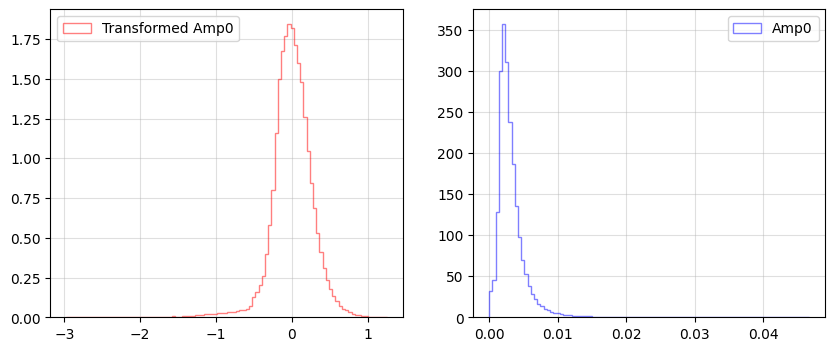

In [14]:
amp0 = data_[:,1]
amp0 = np.log10(amp0)
median_ = np.median(amp0)
amp0 = amp0 - median_

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(amp0, bins=100, alpha=0.5, label='Transformed Amp0', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,1][idx_constrain], bins=100, alpha=0.5, label='Amp0', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [15]:
# this information needs to be save as meta data
print("median: ", median_)
meta_dict["amp0"] = dict(
    median=median_
)

median:  -2.578595991699393


In [16]:
amp0[:10]

array([ 0.1060526 ,  0.02045498,  0.13023723, -0.01858846,  0.20410837,
       -0.13839993,  0.04645657,  0.04990623, -0.35880845, -0.34773981])

In [17]:
# check for invertability
def amp0_forward_transform(amp0, median=-2.578595991699393):
    amp0_ = np.log10(amp0)
    amp0_ = amp0_ - median
    return amp0_

def amp0_backward_transform(amp0_, median=-2.578595991699393):
    amp0_ = 10**(amp0_ + median)
    return amp0_

amp0 = data_[:,1]
print("original: ", amp0[:10])
# forward transform
transformed_amp0 = amp0_forward_transform(amp0)
print("\nforward transform: ", transformed_amp0[:10])
# backward transform
amp0_ = amp0_backward_transform(transformed_amp0)
print("\nbackward transform: ", amp0_[:10])

original:  [0.00336866 0.00276604 0.00356157 0.00252822 0.00422194 0.00191869
 0.00293671 0.00296013 0.00115504 0.00118485]

forward transform:  [ 0.1060526   0.02045498  0.13023723 -0.01858846  0.20410837 -0.13839993
  0.04645657  0.04990623 -0.35880845 -0.34773981]

backward transform:  [0.00336866 0.00276604 0.00356157 0.00252822 0.00422194 0.00191869
 0.00293671 0.00296013 0.00115504 0.00118485]


### $\eta$

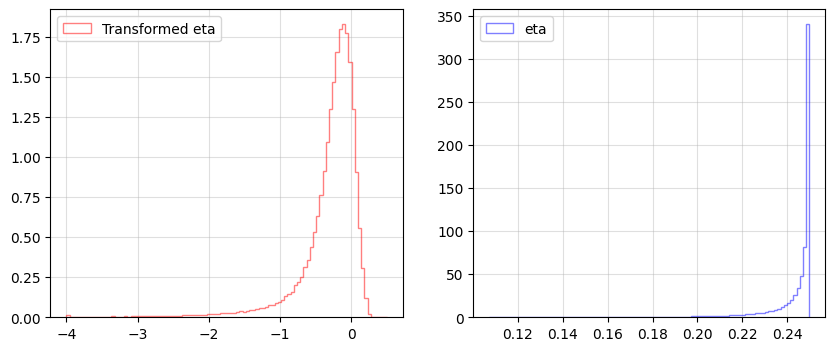

In [18]:
eta = data_[:,2]
# eta = eta[idx_constrain]
min1, max1 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min1, max_data=max1)
eta = sine_to_gaussian(eta)
min2, max2 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min2, max_data=max2)
eta = np.log10(eta)

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(eta, bins=100, alpha=0.5, label='Transformed eta', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,2][idx_constrain], bins=100, alpha=0.5, label='eta', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [19]:
# this information needs to be save as meta data
print("min1: ", min1)
print("max1: ", max1)
print("min2: ", min2)
print("max2: ", max2)
meta_dict["eta"] = dict(
    min1=min1,
    max1=max1,
    min2=min2,
    max2=max2,
)

min1:  0.08741723125122514
max1:  0.24999999999998757
min2:  -5.847172146111127
max2:  5.847172146111127


In [20]:
eta[:10]

array([-0.76713039, -0.17383792, -0.25489035, -1.11858224, -0.52364279,
       -1.08570953, -0.30271796,  0.04046176, -0.34834744, -0.36444465])

In [21]:
# check for invertability
def eta_forward_transform(eta, min1=0.08741723125122514, max1=0.24999999999998757, min2=-5.847172146111127, max2=5.847172146111127):
    eta_ = scale_to_range(eta, min_data=min1, max_data=max1)
    eta_ = sine_to_gaussian(eta_)
    eta_ = scale_to_range(eta_, min_data=min2, max_data=max2)
    eta_ = np.log10(eta_)
    return eta_

def eta_backward_transform(eta_, min1=0.08741723125122514, max1=0.24999999999998757, min2=-5.847172146111127, max2=5.847172146111127):
    eta_ = 10**(eta_)
    eta_ = unscale_to_range(eta_, min_data=min2, max_data=max2)
    eta_ = gaussian_to_sine(eta_)
    eta_ = unscale_to_range(eta_, min_data=min1, max_data=max1)
    return eta_

eta = data_[:,2]
print("original: ", eta[:10])
# forward transform
transformed_eta = eta_forward_transform(eta)
print("\nforward transform: ", transformed_eta[:10])
# backward transform
eta_ = eta_backward_transform(transformed_eta)
print("\nbackward transform: ", eta_[:10])

original:  [0.24997347 0.24793508 0.2490841  0.2499933  0.24989623 0.24999252
 0.24941451 0.22940516 0.24960856 0.24965843]

forward transform:  [-0.76713039 -0.17383792 -0.25489035 -1.11858224 -0.52364279 -1.08570953
 -0.30271796  0.04046176 -0.34834744 -0.36444465]

backward transform:  [0.24997347 0.24793508 0.2490841  0.2499933  0.24989623 0.24999252
 0.24941451 0.22940516 0.24960856 0.24965843]


### $\chi_{eff}$

* no transformation needed

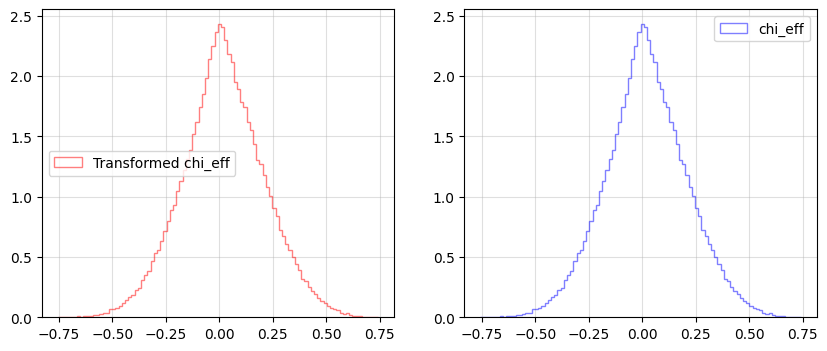

In [22]:
chi_eff = data_[:,3]
# gaussian ppf
# min_ = np.min(chi_eff)
# max_ = np.max(chi_eff)
# chi_eff_ = scale_to_range(chi_eff, min_data=min_, max_data=max_, min_target=0+0.001, max_target=1-0.001)
# chi_eff_ = norm.ppf(chi_eff_)
# chi_eff_ = chi_eff_ - np.median(chi_eff_)
chi_eff_ = chi_eff


# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(chi_eff_, bins=100, alpha=0.5, label='Transformed chi_eff', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,3], bins=100, alpha=0.5, label='chi_eff', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

### $\theta_{jn}$

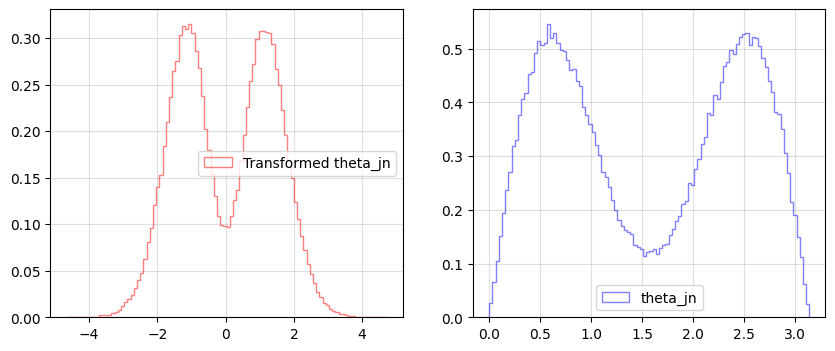

In [26]:
theta_jn = data_[:,4]
theta_jn_ = sine_to_gaussian(theta_jn)

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(theta_jn_, bins=100, alpha=0.5, label='Transformed theta_jn', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,4], bins=100, alpha=0.5, label='theta_jn', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()


In [27]:
theta_jn_[:10]

array([ 0.60551727,  0.11948927, -1.21826869, -0.34974002, -1.10944501,
        2.58188022,  2.42750783, -2.07222575, -2.22653298, -1.21631019])

In [36]:
# check for invertability
def theta_jn_forward_transform(theta_jn):
    theta_jn_ = sine_to_gaussian(theta_jn)
    return theta_jn_

def theta_jn_backward_transform(theta_jn_):
    theta_jn_ = gaussian_to_sine(theta_jn_)
    return theta_jn_

theta_jn = data_[:,4]
print("original: ", theta_jn[:10])
# forward transform
transformed_theta_jn = theta_jn_forward_transform(theta_jn)
print("\nforward transform: ", transformed_theta_jn[:10])
# backward transform
theta_jn_ = theta_jn_backward_transform(transformed_theta_jn)
print("\nbackward transform: ", theta_jn_[:10])

original:  [1.09823921 1.47554008 2.46048874 1.84779107 2.39316795 0.14030327
 0.1745946  2.8641375  2.91315549 2.45930658]

forward transform:  [ 0.60551727  0.11948927 -1.21826869 -0.34974002 -1.10944501  2.58188022
  2.42750783 -2.07222575 -2.22653298 -1.21631019]

backward transform:  [1.09823921 1.47554008 2.46048874 1.84779107 2.39316795 0.14030327
 0.1745946  2.8641375  2.91315549 2.45930658]


### $\rho_{opt}$

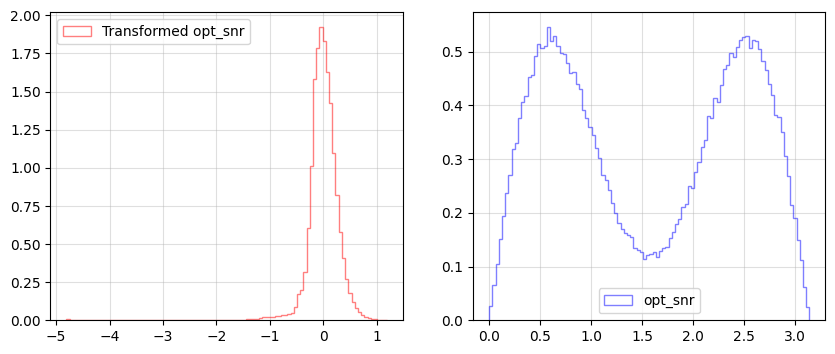

In [30]:
opt_snr = data_[:,5]
opt_snr_ = opt_snr
# change 0 to 0.001
opt_snr_[opt_snr_==0] = 0.0001
opt_snr_ = np.log10(opt_snr)
median_ = np.median(opt_snr_)
opt_snr_ = opt_snr_ - median_

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(opt_snr_, bins=100, alpha=0.5, label='Transformed opt_snr', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,4], bins=100, alpha=0.5, label='opt_snr', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [31]:
# this information needs to be save as meta data
print("median: ", median_)
meta_dict["opt_snr"] = dict(
    median=median_
)

median:  0.807615261055657


In [32]:
opt_snr_[:10]

array([ 0.13714705,  0.01783836,  0.14329293, -0.07114593,  0.2110912 ,
       -0.1625995 ,  0.05927714, -0.04555912, -0.36069917, -0.31269813])

In [37]:
# check for invertability
def opt_snr_forward_transform(opt_snr, median=0.807615261055657):
    opt_snr[opt_snr==0] = 0.0001
    opt_snr_ = np.log10(opt_snr)
    opt_snr_ = opt_snr_ - median
    return opt_snr_

def opt_snr_backward_transform(opt_snr_, median=0.807615261055657):
    opt_snr_ = 10**(opt_snr_ + median)
    opt_snr_[opt_snr_==0.0001] = 0.
    return opt_snr_

opt_snr = data_[:,5]
print("original: ", opt_snr[:10])
# forward transform
transformed_opt_snr = opt_snr_forward_transform(opt_snr)
print("\nforward transform: ", transformed_opt_snr[:10])
# backward transform
opt_snr_ = opt_snr_backward_transform(transformed_opt_snr)
print("\nbackward transform: ", opt_snr_[:10])

original:  [ 8.80566805  6.69042373  8.93116665  5.45091407 10.44014327  4.41586478
  7.36024721  5.78170779  2.79844056  3.12548291]

forward transform:  [ 0.13714705  0.01783836  0.14329293 -0.07114593  0.2110912  -0.1625995
  0.05927714 -0.04555912 -0.36069917 -0.31269813]

backward transform:  [ 8.80566805  6.69042373  8.93116665  5.45091407 10.44014327  4.41586478
  7.36024721  5.78170779  2.79844056  3.12548291]


## Scaling the data

In [38]:
# now scale all
data_ = np.concatenate((XL1, yL1[:,None]), axis=1)
data_new = []
# scale half_snr
half_snr = data_[:,0]
half_snr_ = half_snr_forward_transform(half_snr)
data_new.append(half_snr_)
# scale amp0
amp0 = data_[:,1]
amp0_ = amp0_forward_transform(amp0)
data_new.append(amp0_)
# scale eta
eta = data_[:,2]
eta_ = eta_forward_transform(eta)
data_new.append(eta_)
# scale chi_eff
chi_eff = data_[:,3]
chi_eff_ = chi_eff
data_new.append(chi_eff_)
# scale theta_jn
theta_jn = data_[:,4]
theta_jn_ = theta_jn_forward_transform(theta_jn)
data_new.append(theta_jn_)
# scale opt_snr
opt_snr = data_[:,5]
opt_snr_ = opt_snr_forward_transform(opt_snr)
data_new.append(opt_snr_)

data_new = np.array(data_new).T

In [39]:
XL1 = data_new[:,:-1]
yL1 = data_new[:,-1]

## L1

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

In [41]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

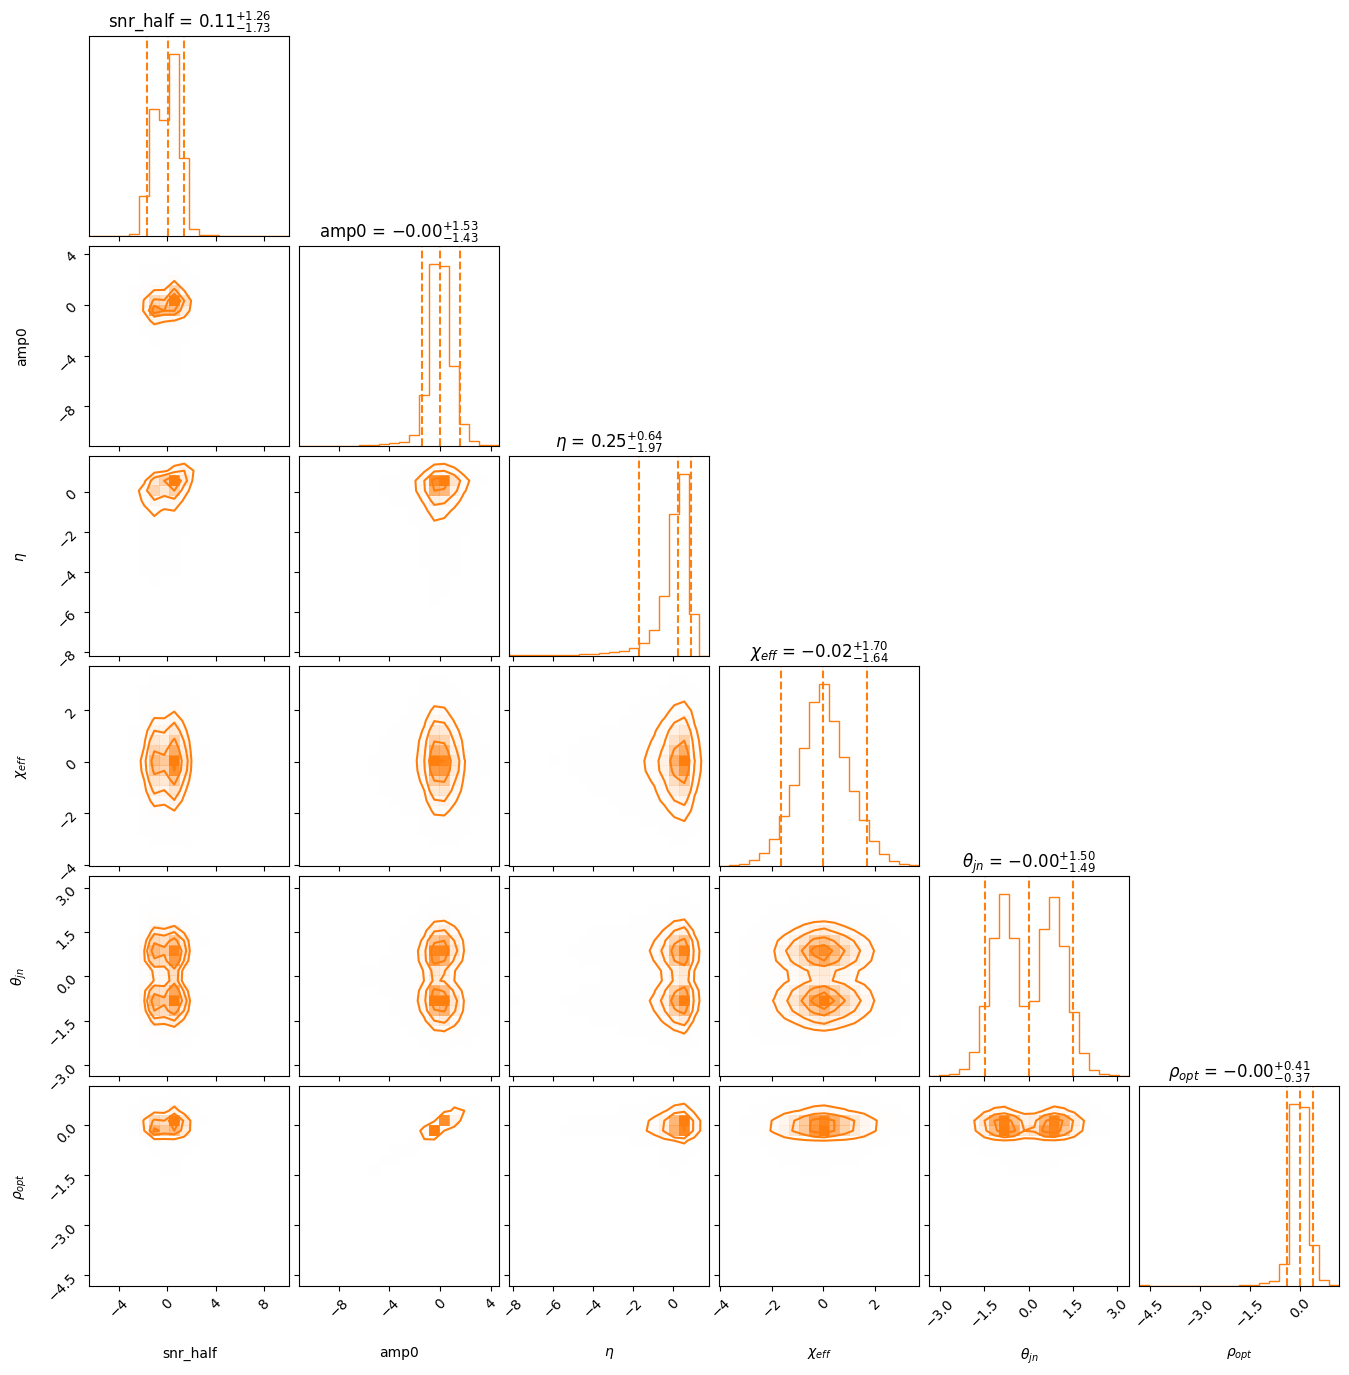

In [42]:
import corner
# plot the corner plot
#concatenate XL1, yL1
data_ = np.concatenate((X_train, y_train[:,None]), axis=1)

labels = [
    r"snr_half",
    r"amp0",
    r"$\eta$",
    r"$\chi_{eff}$",
    r"$\theta_{jn}$",
    r"$\rho_{opt}$",
]
fig = corner.corner(data_,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})
plt.gcf()
plt.show()

In [43]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [44]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [45]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [46]:
# 3m 29.6s multi-threading
# 3m 46.2s single-threading
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 355us/step - accuracy: 0.0000e+00 - loss: 0.0210
Epoch 2/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step - accuracy: 0.0000e+00 - loss: 0.0118
Epoch 3/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - accuracy: 0.0000e+00 - loss: 0.0123
Epoch 4/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step - accuracy: 0.0000e+00 - loss: 0.0111
Epoch 5/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step - accuracy: 0.0000e+00 - loss: 0.0104
Epoch 6/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 330us/step - accuracy: 0.0000e+00 - loss: 0.0095
Epoch 7/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step - accuracy: 0.0000e+00 - loss: 0.0111
Epoch 8/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 355us/step - accuracy: 0.0000e+00 - loss: 0.0079
Epoch 9/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step - accuracy: 0.0000e+00 - loss: 0.0104
Epoch 10/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step - accuracy: 0.0000e+00 - loss: 0.0074
Epoch 11/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 42

In [47]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
[[ 0.04806256  0.06452063]
 [-0.11089797 -0.14966063]
 [-0.16182913 -0.14719593]
 [ 0.106803    0.13267307]
 [-0.10992089 -0.1892166 ]
 [ 0.03641608  0.01541537]
 [-0.30143651 -0.27815962]
 [ 0.39938515  0.39935042]
 [-0.14937827 -0.10808677]
 [-0.16189957 -0.27539242]
 [-0.19205    -0.21698326]
 [ 0.26344162  0.26356382]
 [ 0.04214448  0.0522579 ]
 [-0.27531353 -0.26414845]
 [-0.13536926 -0.15114348]]


In [48]:
y_pred = ann.predict(X_test)
# unscale
y_pred_ = opt_snr_backward_transform(y_pred)

y_test_ = opt_snr_backward_transform(y_test)

print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_test_.reshape(len(y_test_),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
[[ 7.1726203   7.44965038]
 [ 4.97413206  4.54940528]
 [ 4.4237051   4.57529743]
 [ 8.21142006  8.71542029]
 [ 4.98533583  4.15335127]
 [ 6.98282766  6.65320081]
 [ 3.20758915  3.38419704]
 [16.10647392 16.10518351]
 [ 4.55236387  5.00643396]
 [ 4.42298746  3.40582905]
 [ 4.12634277  3.89611709]
 [11.77760124 11.78091668]
 [ 7.07554293  7.24224418]
 [ 3.40644813  3.49515802]
 [ 4.70160389  4.5338984 ]]


In [49]:
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.18%


21686
7720


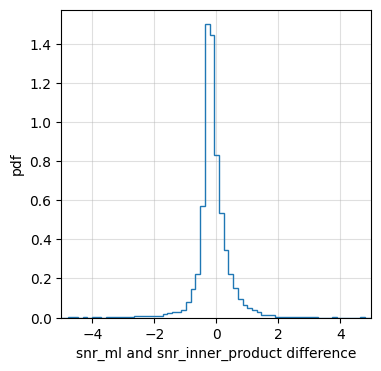

In [50]:
import matplotlib.pyplot as plt

y_pred_ = y_pred_.copy().flatten()
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [41]:
# Save the model to a file
ann.save('ann_modelL1.h5')

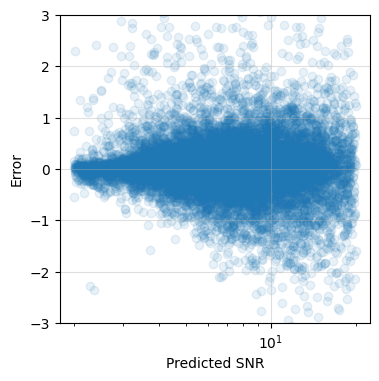

In [51]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = opt_snr_backward_transform(y_pred).flatten()
y_test_ = opt_snr_backward_transform(y_test).flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test_[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## H1

In [496]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['H1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['H1']))

216908
216853


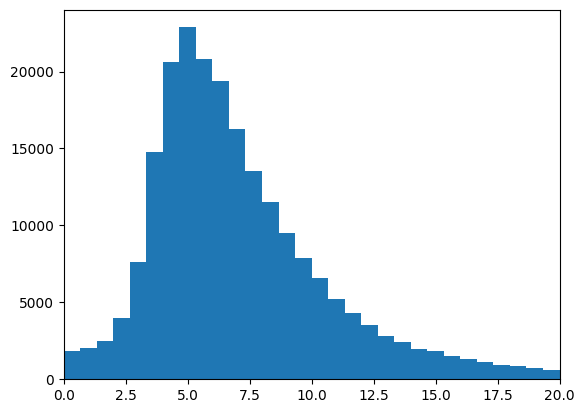

In [497]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['H1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [498]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['H1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['H1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


In [499]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XH1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get H1 snr for y train
    yH1 = params['H1'][idx]

    return(XH1, yH1)

In [500]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XH1, yH1 = input_output(idx, unlensed_params)
np.shape(XH1)

(216853, 5)

In [501]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [502]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [503]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [504]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


6099/6099 [==============================] - 3s 426us/step - loss: 6.0057 - accuracy: 1.0248e-05
Epoch 2/200
6099/6099 [==============================] - 3s 419us/step - loss: 1.0504 - accuracy: 2.5619e-05
Epoch 3/200
6099/6099 [==============================] - 3s 413us/step - loss: 0.7092 - accuracy: 4.0991e-05
Epoch 4/200
6099/6099 [==============================] - 3s 438us/step - loss: 0.6242 - accuracy: 4.0991e-05
Epoch 5/200
6099/6099 [==============================] - 3s 414us/step - loss: 0.5878 - accuracy: 1.5371e-05
Epoch 6/200
6099/6099 [==============================] - 3s 425us/step - loss: 0.5774 - accuracy: 3.5867e-05
Epoch 7/200
6099/6099 [==============================] - 3s 412us/step - loss: 0.5698 - accuracy: 3.0743e-05
Epoch 8/200
6099/6099 [==============================] - 3s 433us/step - loss: 0.5557 - accuracy: 3.0743e-05
Epoch 9/200
6099/6099 [==============================] - 3s 410us/step - loss: 0.5555 - accuracy: 3.0743e-05
Epoch 10/200
6099/6099 [=======

In [505]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 [==============================] - 0s 416us/step
[[35.00002289 37.97115266]
 [ 7.26647186  7.32079747]
 [ 5.22119141  5.49172148]
 [ 8.23579788  7.43225644]
 [ 9.9419899  10.75588391]
 [ 5.19015598  4.36140771]
 [10.4069252  10.10717316]
 [ 5.26541853  4.91636901]
 [ 4.82469225  4.77569326]
 [ 7.35954475  7.67734361]
 [ 3.12154722  3.37646147]
 [ 3.19977927  3.00987443]
 [14.30628777 15.10689954]
 [ 7.97162342  6.18384042]
 [ 9.09439564  8.87853961]]


In [506]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 4.02%


In [507]:
# Save the model to a file
ann.save('ann_modelH1.h5')

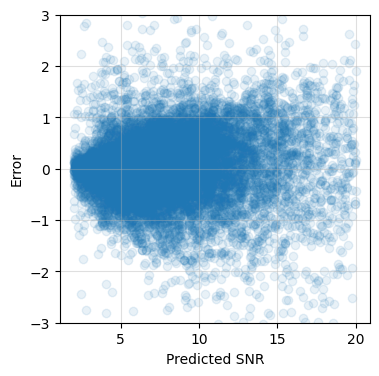

In [508]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## V1

In [509]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['V1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['V1']))

216908
216879


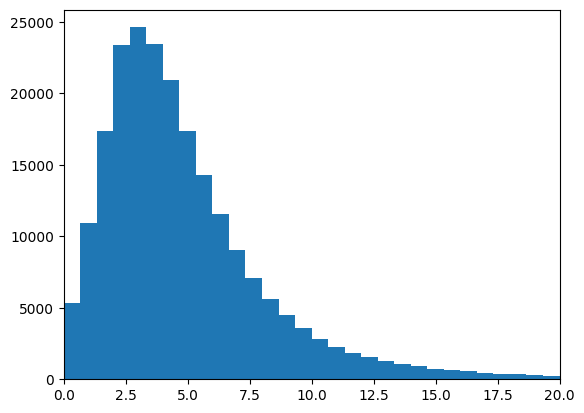

In [510]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['V1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [511]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['V1']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='None')]


In [512]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XV1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get V1 snr for y train
    yV1 = params['V1'][idx]

    return(XV1, yV1)

In [513]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XV1, yV1 = input_output(idx, unlensed_params)
np.shape(XV1)

(216879, 5)

In [514]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [515]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [516]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [517]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


6100/6100 [==============================] - 3s 430us/step - loss: 4.7937 - accuracy: 2.5616e-05
Epoch 2/200
6100/6100 [==============================] - 3s 441us/step - loss: 1.0596 - accuracy: 3.0739e-05
Epoch 3/200
6100/6100 [==============================] - 3s 425us/step - loss: 0.6419 - accuracy: 3.5862e-05
Epoch 4/200
6100/6100 [==============================] - 3s 447us/step - loss: 0.4850 - accuracy: 3.0739e-05
Epoch 5/200
6100/6100 [==============================] - 3s 417us/step - loss: 0.4213 - accuracy: 2.5616e-05
Epoch 6/200
6100/6100 [==============================] - 3s 440us/step - loss: 0.3833 - accuracy: 1.5370e-05
Epoch 7/200
6100/6100 [==============================] - 3s 420us/step - loss: 0.3560 - accuracy: 3.0739e-05
Epoch 8/200
6100/6100 [==============================] - 3s 434us/step - loss: 0.3462 - accuracy: 3.5862e-05
Epoch 9/200
6100/6100 [==============================] - 3s 417us/step - loss: 0.3355 - accuracy: 1.5370e-05
Epoch 10/200
6100/6100 [=======

In [518]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 [==============================] - 0s 335us/step


[[13.49041462 13.5532527 ]
 [ 4.03706074  4.11572358]
 [ 8.59361839  7.79521397]
 [ 2.1222508   2.16101504]
 [ 4.0793047   4.08103545]
 [ 2.22639751  2.08412741]
 [ 8.18501854  6.70793353]
 [ 5.5151701   5.41165149]
 [ 4.33706999  3.41114713]
 [ 2.18644643  2.22421085]
 [ 4.75796366  9.33814207]
 [ 3.4946394   3.29469341]
 [ 3.73273301  3.8705105 ]
 [ 5.85980892  6.1987328 ]
 [ 6.52721453  6.81462945]]


In [519]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.98%


In [520]:
# Save the model to a file
ann.save('ann_modelV1.h5')

## Load all models and test them

In [521]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

## BBH

In [522]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds


You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10

In [523]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T    

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(np.array(params['L1'])[idx]**2 + np.array(params['H1'])[idx]**2 + np.array(params['V1'])[idx]**2)

    # taking care mtot max
    # mtot_max = gwsnr.mtot_max
    # mtot = mass_1[idx] + mass_2[idx]
    # y[mtot>mtot_max] = 0.

    return(X,y)

In [524]:
# generating new data
from ler.rates import LeR
from ler.utils import get_param_from_json
import numpy as np

ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

In [525]:
## Uncomment to generate new data if not already generated
size_ = 25000
ler.batch_size = 25000
ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=True);

unlensed params will be store in ./ler_data/unlensed_param_testing.json
chosen batch size = 25000 with total size = 25000
There will be 1 batche(s)
resuming from ./ler_data/unlensed_param_testing.json
saving all unlensed_params in ./ler_data/unlensed_param_testing.json...


In [526]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [527]:
X_, Y_ = input_output_net(np.arange(size_), unlensed_params)

In [528]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(x_array,y)

In [529]:
_, snrANN =input_output_netANN(X_)

782/782 [==============================] - 0s 261us/step


In [530]:
y_pred = snrANN.flatten()
y_test = Y_

In [531]:
len(y_test)

25000

In [532]:
len(y_pred)

25000

In [563]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<12)
popt, pcov = curve_fit(func, y_pred[idx], y_pred[idx]-y_test[idx])
print(popt)

[-0.07411881  0.87044046]


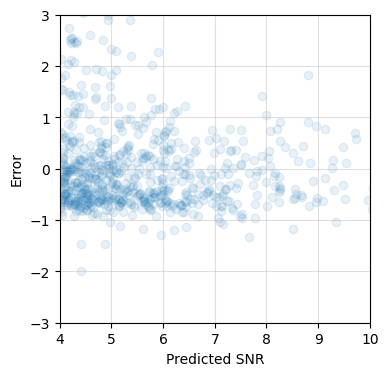

In [564]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
y_pred_ = y_pred_-(popt[0]*y_pred+popt[1])
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test[idx], alpha=0.1)
#plt.scatter(y_test[idx], y_pred_[idx]-y_test[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

25000
777


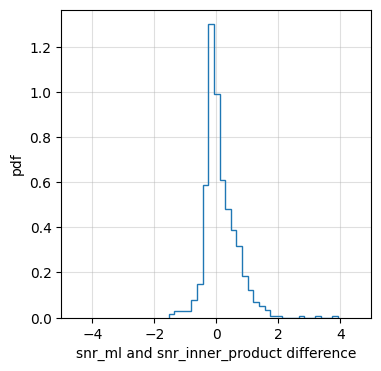

In [565]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [562]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1120%


In [566]:
len1 = len(y_pred)
len2 = np.sum(((y_pred-(popt[0]*y_pred+popt[1]))>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1040%


In [567]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.0)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24869    18]
 [   10   103]]


0.99888

In [568]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.2)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24875    12]
 [   14    99]]


0.99888

In [569]:
#y_pred = (y_pred > 0.5)
idx = (y_test>7) & (y_pred<9)
print(np.concatenate((y_pred.reshape(len(y_pred),1)-0.2, y_test.reshape(len(y_test),1)),1)[idx][:10])

[[6.98862362 7.3244188 ]
 [8.07498264 8.73664642]
 [8.58827877 9.05212486]
 [6.86917257 7.01070622]
 [7.88767624 8.33806557]
 [7.8469162  8.45750222]
 [8.56952381 8.94146165]
 [8.12943077 7.33984516]
 [7.83821392 7.59029936]
 [6.58561087 7.04858059]]


## BNS

In [540]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [541]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


  1%|▌                                                          | 527/50000 [00:10<17:00, 48.47it/s]


KeyboardInterrupt: 

In [ ]:
from ler.utils import get_param_from_json
unlensed_params = get_param_from_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined